In [1]:
import os
import numpy as np
import cPickle as pickle
import itertools
from keras.preprocessing import image
import keras.backend as K
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Image
import matplotlib.pyplot as plt
from logger import logger
%matplotlib inline

Using Theano backend.


In [2]:
from keras.layers import merge, Input
from keras.layers import Dense, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file

In [3]:
def load_dict(dict_dir='categorize', dict_name='tfidf_dict'):
    """ (str, str) -> defaultdict

    Loads a dictionary for categorization into memory

    :param tfidf_dict:
    :param dict_dir:
    :param dict_name:
    :return:
    """
    output_dir_path = os.path.join(dict_dir, dict_name + '.pickle')

    with open(output_dir_path, 'rb') as handle:
        logger.info('Dictionary loading from: {}/{}.pickle'.format(dict_dir, dict_name))
        return pickle.load(handle)

In [4]:
MAIN_DIR = 'images'

### Load search dictionaries

In [5]:
index_asin_dict, category_index_dict, index_asin_filter_dict, asin_dict = load_dict('../data/' + MAIN_DIR + '/search_dicts', 'search_dicts')

2016-12-29 18:48:47,042 - Dictionary loading from: ../data/images/search_dicts/search_dicts.pickle


In [6]:
index_asin_dict

defaultdict(None,
            {0: 'B00KBZEOBU',
             1: 'B00KCFPKY4',
             2: 'B00KCLOFQ2',
             3: 'B00KCLSY64',
             4: 'B00KD15484',
             5: 'B00KD7KPZK',
             6: 'B00KERDISU',
             7: 'B00KFW3NUW',
             8: 'B00KFZ5WUS',
             9: 'B00KG0X1DW',
             10: 'B00KH7ZZ9C',
             11: 'B00KHA2YDO',
             12: 'B00KIWCZ4Y',
             13: 'B00KIWMR5Q',
             14: 'B00KIY40CW',
             15: 'B00KJ4WTG0',
             16: 'B00KJLMBQQ',
             17: 'B00KJLMBSO',
             18: 'B00KQ15030',
             19: 'B00KQHW6F4',
             20: 'B00KREXJ52',
             21: 'B00KS3EP28',
             22: 'B00KT3ZNSM',
             23: 'B00KVJ73LE',
             24: 'B00KW022JA',
             25: 'B00KWNTTOI',
             26: 'B00KWW3VVQ',
             27: 'B00KWWCFDQ',
             28: 'B00KWWMT0U',
             29: 'B00KX9ANEG',
             30: 'B00KYGP50K',
             31: 'B00L38XJ2Y',


In [7]:
category_index_dict

defaultdict(None,
            {'Cell Phones & Accessories': (0, 36),
             'Clothing, Shoes & Jewelry': (1, 36),
             'Home & Kitchen': (2, 48),
             'Toys & Games': (3, 52)})

In [8]:
category_index_dict

defaultdict(None,
            {'Cell Phones & Accessories': (0, 36),
             'Clothing, Shoes & Jewelry': (1, 36),
             'Home & Kitchen': (2, 48),
             'Toys & Games': (3, 52)})

In [9]:
index_asin_filter_dict

defaultdict(None,
            {0: defaultdict(None,
                         {0: 'B00KBZEOBU',
                          1: 'B00KCFPKY4',
                          2: 'B00KCLOFQ2',
                          3: 'B00KCLSY64',
                          4: 'B00KD15484',
                          5: 'B00KD7KPZK',
                          6: 'B00KERDISU',
                          7: 'B00KFW3NUW',
                          8: 'B00KFZ5WUS',
                          9: 'B00KG0X1DW',
                          10: 'B00KH7ZZ9C',
                          11: 'B00KHA2YDO',
                          12: 'B00KIWCZ4Y',
                          13: 'B00KIWMR5Q',
                          14: 'B00KIY40CW',
                          15: 'B00KJ4WTG0',
                          16: 'B00KJLMBQQ',
                          17: 'B00KJLMBSO',
                          18: 'B00KQ15030',
                          19: 'B00KQHW6F4',
                          20: 'B00KREXJ52',
                          21: 'B00

In [8]:
asin_dict['B001SEQQB4']

('data/images/train_top_level/Toys & Games/B001SEQQB4.jpg',
 'Power Wheels Kawasaki KFX with Monster Traction, Normal',
 'Toys & Games -> Tricycles, Scooters & Wagons -> Ride-On Toys')

### Load search features

In [11]:
search_features = np.load(open('../data/' + MAIN_DIR + '/search_features/search_features.npy'))

In [12]:
# Add index to search features
category_labels = list(itertools.chain.from_iterable([tup[0]] * tup[1] for tup in category_index_dict.values()))
category_labels.reverse()

In [13]:
search_features = np.insert(search_features, 0, category_labels, axis=1)

### Load model

In [16]:
model = InceptionV3(include_top=False, weights='imagenet', input_tensor=None)

###  Loop function for cosine similarity

In [17]:
from scipy.spatial.distance import cosine

In [18]:
def get_cosine_similarity_scipy(row, search_image_features):
    return 1 - cosine(row, search_image_features)

In [19]:
def cosine_similarity_scipy(search_image_features, search_features):
    return np.apply_along_axis(get_cosine_similarity_scipy, axis=1, arr=search_features, search_image_features=search_image_features)

### Search Image Single

In [20]:
def prepare_image(image_path, img_width, img_height):
    """

    Returns an image array given of the image in path

    :param image_path:
    :param img_width:
    :param img_height:
    :return:
    """
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.multiply(img, 1. / 255)
    img = np.expand_dims(img, axis=0)

    return img

In [21]:
valid_categories = category_index_dict.keys() + ['All']

In [22]:
valid_categories

['Toys & Games',
 'Home & Kitchen',
 'Clothing, Shoes & Jewelry',
 'Cell Phones & Accessories',
 'All']

In [23]:
category_filter = 'test'

In [24]:
assert category_filter in valid_categories, 'Category "{}" invalid'.format(category_filter)

AssertionError: Category "test" invalid

In [61]:
class ImageSearch:

    def __init__(self, image_path, category_filter='All'):
        self.image_path = image_path
        self.image = None
        self.image_width = 299
        self.image_height = 299
        self.category_filter = category_filter
        self.category_filter_index = -1
        self.similarity_threshold = 0.60
        self.n_results = 10
        logger.info('Image (search) initialized')

        assert self.category_filter in valid_categories, 'Category "{}" invalid'.format(self.category_filter)

    def get_category_filter_index(self):
        if self.category_filter == 'All':
            self.category_filter_index = -1
        else:
            self.category_filter_index = category_index_dict[self.category_filter][0]

        logger.info('Image (search) category filter index got')
        return self

    def prepare(self):
        self.image = prepare_image(self.image_path, self.image_width, self.image_height)
        logger.info('Image (search) prepared')
        return self

    def search_similar(self):

        # Featurize search image
        search_image = model.predict(self.image)

        # Filter search features if necessary
        if self.category_filter_index == -1:
            search_features_filtered = search_features[:, 1:]
            image_lookup_dict = index_asin_dict
        else:
            category_filter = search_features[:, 0] == self.category_filter_index
            search_features_filtered = search_features[category_filter, 1:]
            image_lookup_dict = index_asin_filter_dict[self.category_filter_index]

        # Get cosine similarity
        # csim = cosine_similarity(search_image, search_features_filtered)[0]
        csim = cosine_similarity_scipy(search_image, search_features_filtered)

        # Get index of similar features
        similar_images = np.argsort(-csim)[:self.n_results]

        # Exclude similar images below the similarity threshold
        similar_images = [idx for idx in similar_images if csim[idx] > self.similarity_threshold]

        # Initialize result dict
        results = dict()
        result_index = 0

        for index in similar_images:
            asin = image_lookup_dict[index]
            results[result_index] = asin_dict[asin]
            result_index += 1

        logger.info('Image (search) searched')
        return results

In [62]:
# print ImageSearch(search_image_path, 'All').get_category_filter_index().category_filter_index

In [63]:
# print ImageSearch(search_image_path, 'All').prepare().image.shape

In [64]:
# print ImageSearch(search_image_path, 'All').prepare().search_similar()

In [65]:
# image_search_result = ImageSearch(search_image_path, 'All').get_category_filter_index().prepare().search_similar()

In [66]:
def image_search(image_path, category_filter='All'):
    """

    Initializes given image path as ImageSearch class and returns a dictionary of top 5 options

    :param image_path:
    :return:
    """
    return ImageSearch(image_path, category_filter).get_category_filter_index().prepare().search_similar()

In [67]:
valid_categories

['Toys & Games',
 'Home & Kitchen',
 'Clothing, Shoes & Jewelry',
 'Cell Phones & Accessories',
 'All']

../data/images_sample/search_image/B00HCP0VTQ.jpg


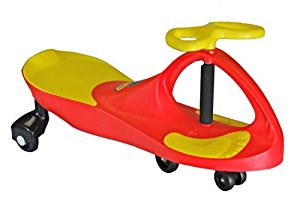

In [68]:
search_image_dir_path = '../data/images_sample/search_image/'
search_images = os.listdir(search_image_dir_path)
search_images = [search_image for search_image in search_images if not search_image.startswith('.')]
search_image_path = os.path.join(search_image_dir_path, search_image)
print search_image_path
Image(search_image_path, width=100, height=100)

In [69]:
search_results = image_search(search_image_path, 'All')

2016-12-27 20:28:52,126 - Image (search) initialized
2016-12-27 20:28:52,127 - Image (search) category filter index got
2016-12-27 20:28:52,131 - Image (search) prepared
2016-12-27 20:28:52,489 - Image (search) searched


../data/images_sample/train_top_level/Toys & Games/B00HCP0VTQ.jpg
PlasmaCar Red and Yellow Special Limited Edition
Toys & Games -> Tricycles, Scooters & Wagons -> Ride-On Toys

../data/images_sample/train_top_level/Toys & Games/B00HCP29GO.jpg
PlasmaCar Robin Egg and Purple Special Limited Edition
Toys & Games -> Tricycles, Scooters & Wagons -> Ride-On Toys

../data/images_sample/train_top_level/Toys & Games/B00HCP4ZHU.jpg
PlasmaCar Lime and Navy Blue Special Limited Edition
Toys & Games -> Tricycles, Scooters & Wagons -> Ride-On Toys

../data/images_sample/train_top_level/Toys & Games/B00JFG7ZN0.jpg
PlasmaCar Pink &amp; Orange - Polyurethane Wheels Special Edition
Toys & Games -> Tricycles, Scooters & Wagons -> Ride-On Toys

../data/images_sample/train_top_level/Toys & Games/B00HEPDC0Y.jpg
Swing Car , Swivel Car - JoybayTM The Original Swing Car (Classical Red)
Toys & Games -> Tricycles, Scooters & Wagons -> Ride-On Toys

../data/images_sample/train_top_level/Toys & Games/B00IUPZ5Y8.jp

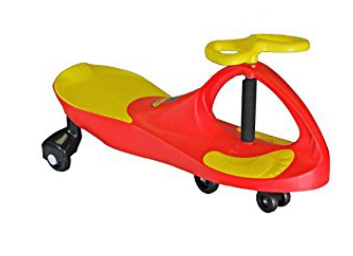

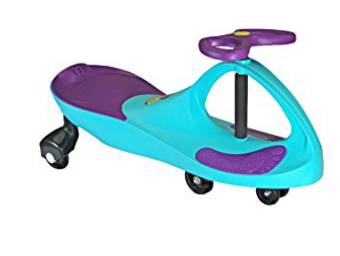

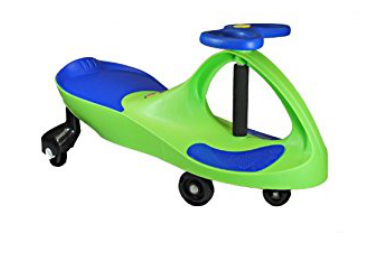

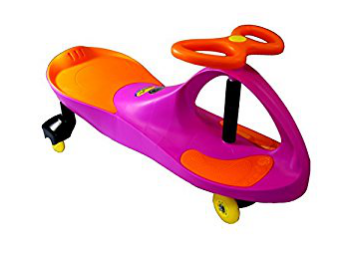

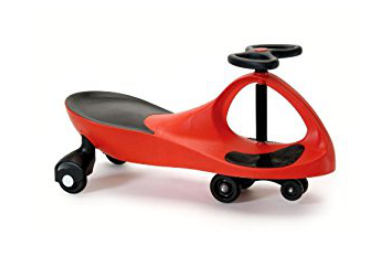

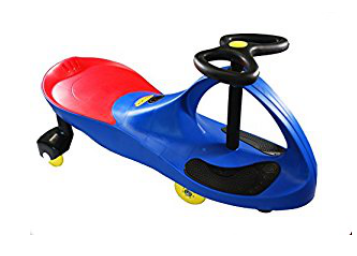

In [70]:
for result in search_results.values():
    image_path = '../' + result[0]
    title = result[1]
    category = result[2]
    print image_path
    print title
    print category
    image_display = plt.imread(image_path)
    plt.axis('off')
    plt.imshow(image_display.astype('uint8'))
    plt.figure()
    print ''

In [15]:
TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_th_dim_ordering_th_kernels.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


def conv2d_bn(x, nb_filter, nb_row, nb_col,
              border_mode='same', subsample=(1, 1),
              name=None):
    '''
    Utility function to apply conv + BN.
    '''
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_dim_ordering() == 'th':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample,
                      activation='relu',
                      border_mode=border_mode,
                      name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name)(x)
    return x


def InceptionV3(include_top=True, weights='imagenet',
                input_tensor=None):
    '''Instantiate the Inception v3 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    Note that the default input image size for this model is 299x299.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.

    # Returns
        A Keras model instance.
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 299, 299)
        else:
            input_shape = (3, 299, 299)
    else:
        if include_top:
            input_shape = (299, 299, 3)
        else:
            input_shape = (299, 299, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor

    if K.image_dim_ordering() == 'th':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, subsample=(2, 2), border_mode='valid')
    # with stride=2 border='valid', output becomes (299-1)/2 = 149 x 149
    x = conv2d_bn(x, 32, 3, 3, border_mode='valid')  # 149 - 2 = 147 x 147
    x = conv2d_bn(x, 64, 3, 3)  # 147 x 147
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # 49

    x = conv2d_bn(x, 80, 1, 1, border_mode='valid')
    x = conv2d_bn(x, 192, 3, 3, border_mode='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    for i in range(3):
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
        x = merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(i))

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, subsample=(2, 2), border_mode='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3,
                             subsample=(2, 2), border_mode='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = merge([branch3x3, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 160, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          subsample=(2, 2), border_mode='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3,
                            subsample=(2, 2), border_mode='valid')

    branch_pool = AveragePooling2D((3, 3), strides=(2, 2))(x)
    x = merge([branch3x3, branch7x7x3, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = merge([branch3x3_1, branch3x3_2],
                          mode='concat', concat_axis=channel_axis,
                          name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = merge([branch3x3dbl_1, branch3x3dbl_2],
                             mode='concat', concat_axis=channel_axis)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = merge([branch1x1, branch3x3, branch3x3dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(9 + i))

    x = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)  # Moved here for transfer learning
    
    x = Flatten(name='flatten')(x)

    if include_top:
        # Classification block
        # x = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)
        # x = Flatten(name='flatten')(x)
        x = Dense(1000, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(img_input, x)

    # load weights
    if weights == 'imagenet':
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('inception_v3_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='b3baf3070cc4bf476d43a2ea61b0ca5f')
            else:
                weights_path = get_file('inception_v3_weights_th_dim_ordering_th_kernels_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='79aaa90ab4372b4593ba3df64e142f05')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='fe114b3ff2ea4bf891e9353d1bbfb32f')
            else:
                weights_path = get_file('inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='2f3609166de1d967d1a481094754f691')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model